# Import data

In [1]:
import pandas as pd
import numpy as np

sample_emb_df = pd.read_csv('./sample_emb_df_MOLE.csv')
df_abund_samples = pd.read_csv('./df_abund_samples.csv')  # row by sample, colomn by feature, with abundance data

In [57]:
df_all = sample_emb_df.join(
    df_abund_samples[["Age", "antibiotic", "immunosuppressant", "mesalamine", "steroids"]],
    how="inner"
)

print(df_all.shape)
df_all.head()

(220, 776)


,SampleID,Diagnosis,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,...,emb_764,emb_765,emb_766,emb_767,IBD_status,Age,antibiotic,immunosuppressant,mesalamine,steroids
0,PRISM|7122,CD,-0.805473,-0.718104,-1.200143,-0.471288,0.235217,1.919869,-0.819779,0.472737,...,0.676845,0.461640,0.343551,-1.292151,IBD,38,No,Yes,No,No
1,PRISM|7147,CD,-0.777292,-0.710630,-1.147591,-0.458976,0.225503,1.957557,-0.743333,0.505915,...,0.610866,0.471042,0.328423,-1.271181,IBD,50,No,No,Yes,No
2,PRISM|7150,CD,-0.805334,-0.692002,-1.177567,-0.437340,0.291231,1.908967,-0.758670,0.501228,...,0.665981,0.485440,0.305063,-1.284811,IBD,41,No,Yes,No,No
3,PRISM|7153,CD,-0.826512,-0.699231,-1.267495,-0.548747,0.205837,1.924771,-0.853242,0.570224,...,0.666138,0.497184,0.336961,-1.339021,IBD,51,No,No,Yes,No
4,PRISM|7184,CD,-0.805571,-0.726238,-1.287693,-0.527005,0.215771,1.983378,-0.843859,0.528638,...,0.671120,0.541878,0.346897,-1.363042,IBD,68,No,No,No,No


In [58]:
# Diagnosis: 'Control', 'UC', 'CD'
# df_all["IBD_status"] = np.where(df_all["Diagnosis"] == "Control", "Non-IBD", "IBD")

df_all[["Diagnosis", "IBD_status"]].head()

,Diagnosis,IBD_status
0,CD,IBD
1,CD,IBD
2,CD,IBD
3,CD,IBD
4,CD,IBD


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

emb_cols = [c for c in df_all.columns if c.startswith("emb_")]

X = df_all[emb_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df_all["PC1"] = X_pca[:, 0]
df_all["PC2"] = X_pca[:, 1]

print("PCA explained variance ratio:", pca.explained_variance_ratio_)
df_all[["PC1", "PC2", "Diagnosis", "Age"]].head()

PCA explained variance ratio: [0.44682858 0.20871086]


,PC1,PC2,Diagnosis,Age
0,15.857102,-18.871768,CD,38
1,22.637218,-17.683126,CD,50
2,28.984326,-8.551418,CD,41
3,-12.700784,-15.764340,CD,51
4,-1.567063,-7.616541,CD,68


In [60]:
import umap.umap_ as umap

reducer = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    random_state=42
)

X_umap = reducer.fit_transform(X_scaled)

df_all["UMAP1"] = X_umap[:, 0]
df_all["UMAP2"] = X_umap[:, 1]

df_all[["UMAP1", "UMAP2", "Diagnosis"]].head()

c:\Users\MY2\miniconda3\envs\mitai\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


,UMAP1,UMAP2,Diagnosis
0,-5.073053,-1.367390,CD
1,-4.809160,-0.193594,CD
2,-4.751472,-0.800220,CD
3,-7.160347,-1.326321,CD
4,-5.898472,-2.225501,CD


# Visualization (stratify by Non-IBD and IBD)

In [61]:
import matplotlib.pyplot as plt
def plot_by_age(df, use_umap=False):
    if use_umap:
        x_col, y_col = "UMAP1", "UMAP2"
        title = "UMAP of sample embeddings colored by age"
    else:
        x_col, y_col = "PC1", "PC2"
        title = "PCA of sample embeddings colored by age"
    
    ibd_levels = ["Non-IBD", "IBD"]
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True, constrained_layout=True)
    
    for ax, status in zip(axes, ibd_levels):
        sub = df[df["IBD_status"] == status]
        sc = ax.scatter(
            sub[x_col],
            sub[y_col],
            c=sub["Age"],
            alpha=0.8
        )
        ax.set_title(status)
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
    
    fig.suptitle(title)
    cbar = fig.colorbar(sc, ax=axes.ravel().tolist(), label="Age")
    plt.show()

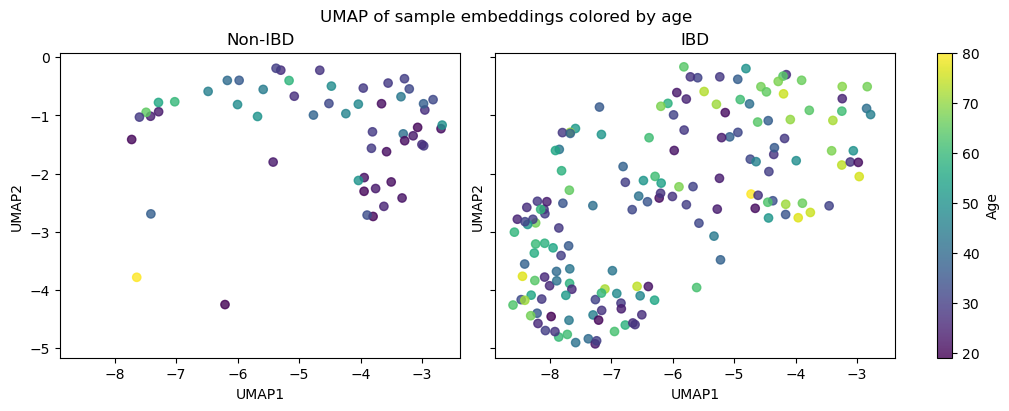

In [ ]:
plot_by_age(df_all, use_umap=True)

In [ ]:
def plot_by_binary_var(df, var, use_umap=False):
    """
    var: strings, link "antibiotic", "immunosuppressant", "mesalamine", "steroids"
    """
    if use_umap:
        x_col, y_col = "UMAP1", "UMAP2"
    else:
        x_col, y_col = "PC1", "PC2"
    
    vals = df[var].map({"Yes": 1, "No": 0})
    
    df_plot = df.copy()
    df_plot[var + "_bin"] = vals.astype(float)  
    
    ibd_levels = ["Non-IBD", "IBD"]
    colors = {0.0: "tab:blue", 1.0: "tab:red"}
    labels = {0.0: "No " + var, 1.0: "Yes " + var}
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
    
    for ax, status in zip(axes, ibd_levels):
        sub = df_plot[df_plot["IBD_status"] == status]
        
        for val in [0.0, 1.0]:
            sub_sub = sub[sub[var + "_bin"] == val]
            if len(sub_sub) == 0:
                continue
            ax.scatter(
                sub_sub[x_col],
                sub_sub[y_col],
                label=labels[val],
                color=colors[val],
                alpha=0.8
            )
        ax.set_title(status)
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        ax.legend()
    
    plt.suptitle(f"{x_col}/{y_col} colored by {var} (stratified by IBD)")
    plt.tight_layout()
    plt.show()

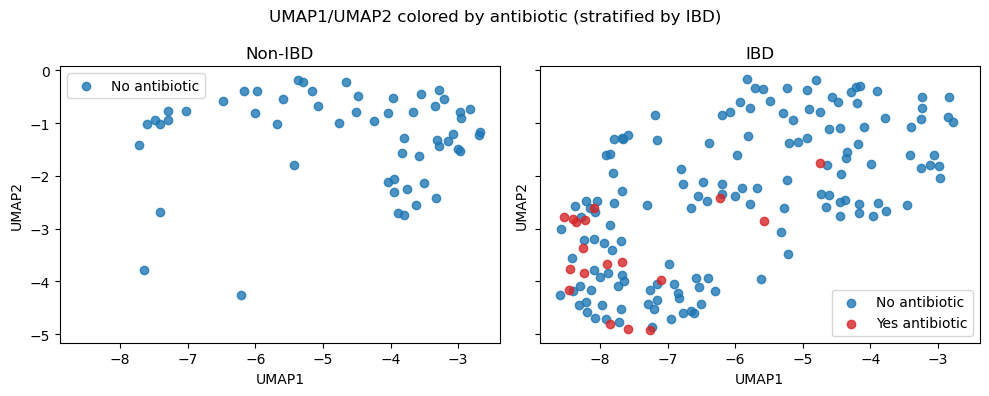

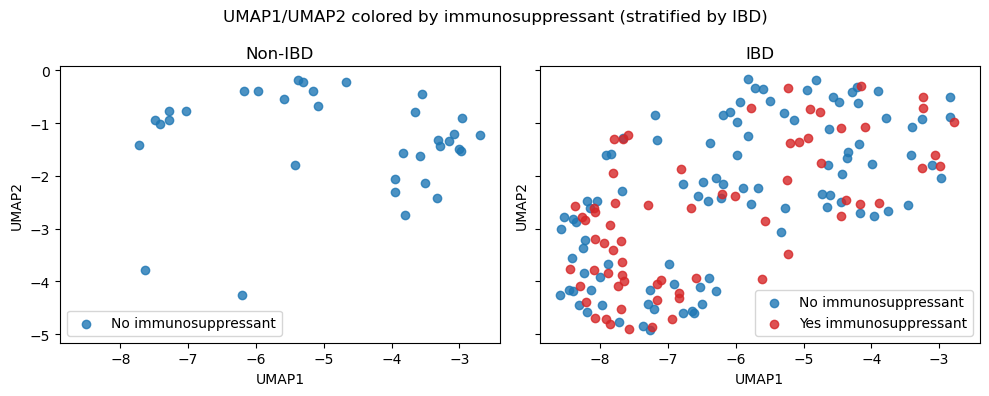

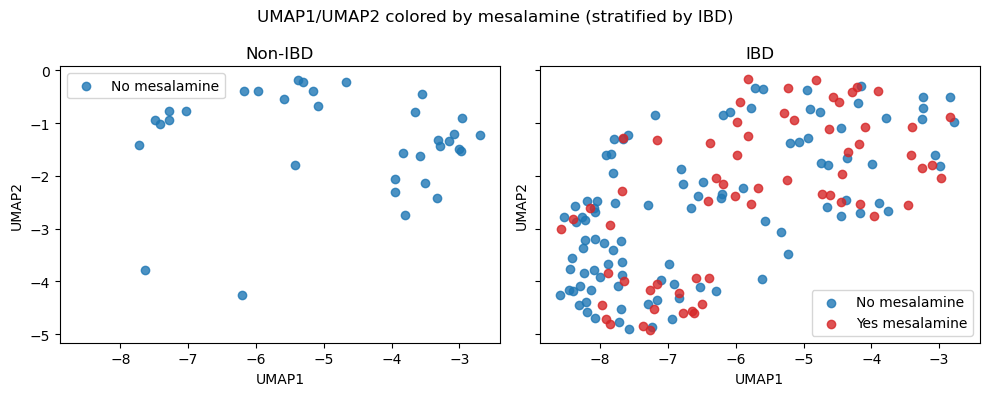

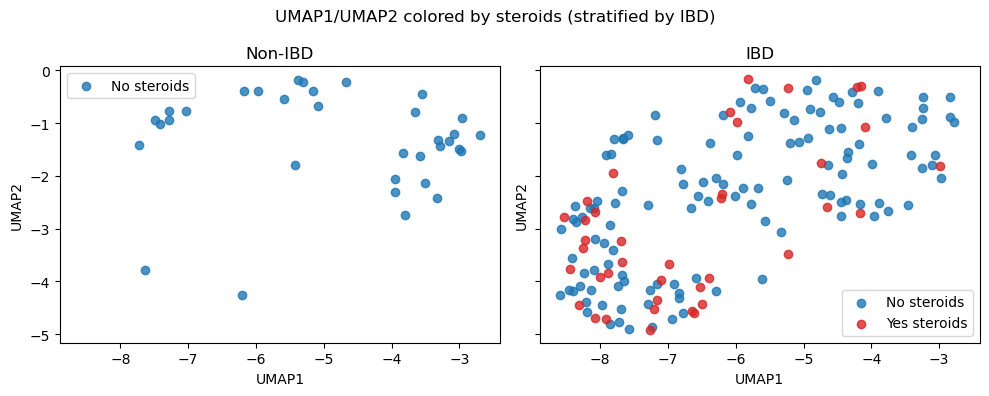

In [ ]:
for var in ["antibiotic", "immunosuppressant", "mesalamine", "steroids"]:
    # plot_by_binary_var(df_all, var, use_umap=False)   # use PCA
    plot_by_binary_var(df_all, var, use_umap=True)


# Visualization (stratify by Control/UC/CD)

In [ ]:
def plot_by_age_uc_cd(df, use_umap=False):
    if use_umap:
        x_col, y_col = "UMAP1", "UMAP2"
        title = "UMAP of sample embeddings colored by age"
    else:
        x_col, y_col = "PC1", "PC2"
        title = "PCA of sample embeddings colored by age"
    
    diag_levels = ["Control", "UC", "CD"]

    fig, axes = plt.subplots(
        1, 3,
        figsize=(9, 4),             
        sharex=True,
        sharey=True,
        constrained_layout=True    
    )
    
    for ax, diag in zip(axes, diag_levels):
        sub = df[df["Diagnosis"] == diag] 
        sc = ax.scatter(
            sub[x_col],
            sub[y_col],
            c=sub["Age"],
            alpha=0.8
        )
        ax.set_title(diag)
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
    
    fig.suptitle(title)
    cbar = fig.colorbar(sc, ax=axes.ravel().tolist(), label="Age")
    plt.show()

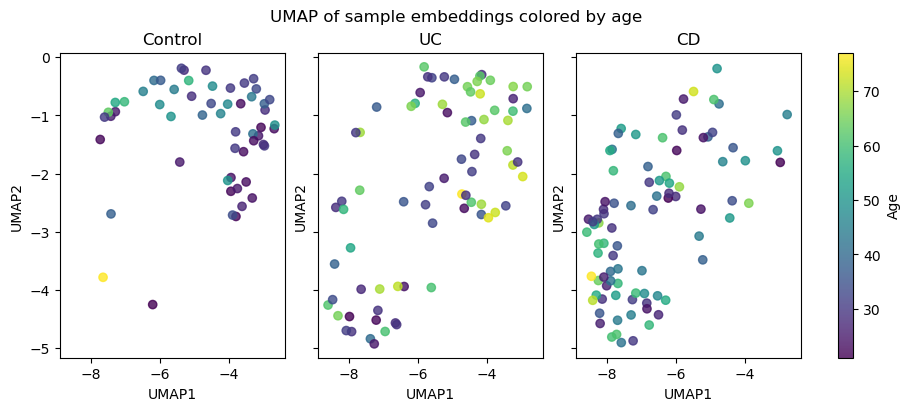

In [66]:
plot_by_age_uc_cd(df_all, use_umap=True)


In [ ]:
def plot_by_binary_var_3groups(df, var, use_umap=False):
    if use_umap:
        x_col, y_col = "UMAP1", "UMAP2"
    else:
        x_col, y_col = "PC1", "PC2"
    
    vals = df[var].map({"Yes": 1, "No": 0})
    
    df_plot = df.copy()
    df_plot[var + "_bin"] = vals.astype(float)   
    
    group_col = "Diagnosis"
    groups = ["Control", "UC", "CD"]
    
    colors = {0.0: "tab:blue", 1.0: "tab:red"}
    labels = {0.0: "No " + var, 1.0: "Yes " + var}
    
    fig, axes = plt.subplots(
        1, 3,
        figsize=(12, 4),
        sharex=True,
        sharey=True
    )
    
    for ax, grp in zip(axes, groups):
        sub = df_plot[df_plot[group_col] == grp]
        
        for val in [0.0, 1.0]:
            sub_sub = sub[sub[var + "_bin"] == val]
            if len(sub_sub) == 0:
                continue
            ax.scatter(
                sub_sub[x_col],
                sub_sub[y_col],
                label=labels[val],
                color=colors[val],
                alpha=0.8
            )
        
        ax.set_title(grp)
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        ax.legend()
    
    plt.suptitle(f"{x_col}/{y_col} colored by {var} (stratified by Control / UC / CD)")
    plt.tight_layout()
    plt.show()

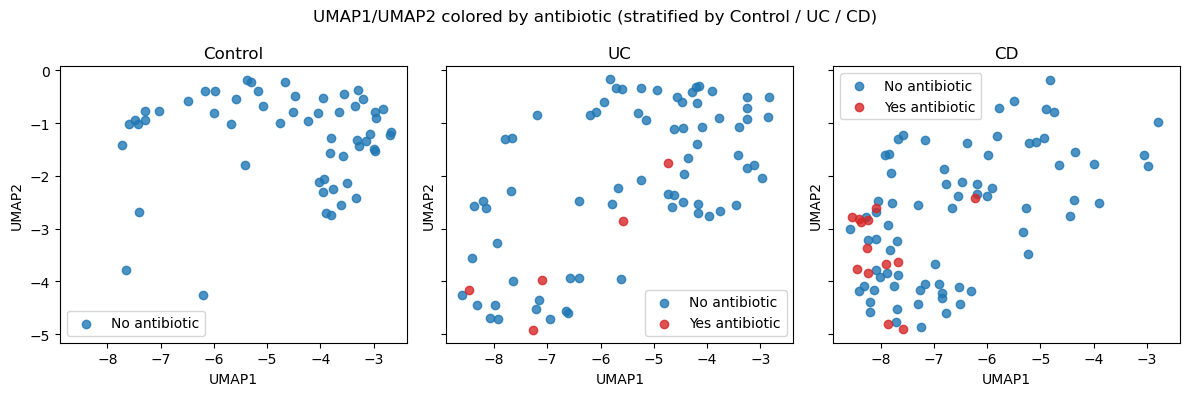

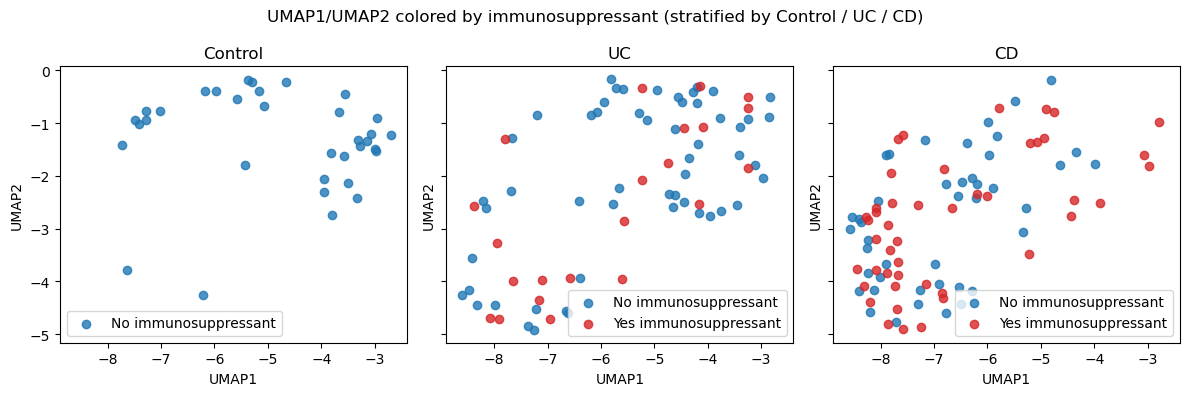

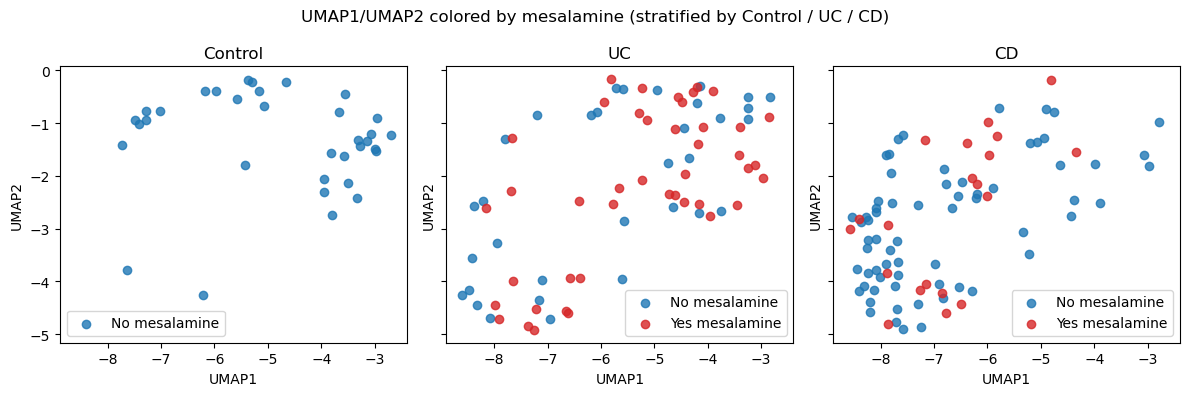

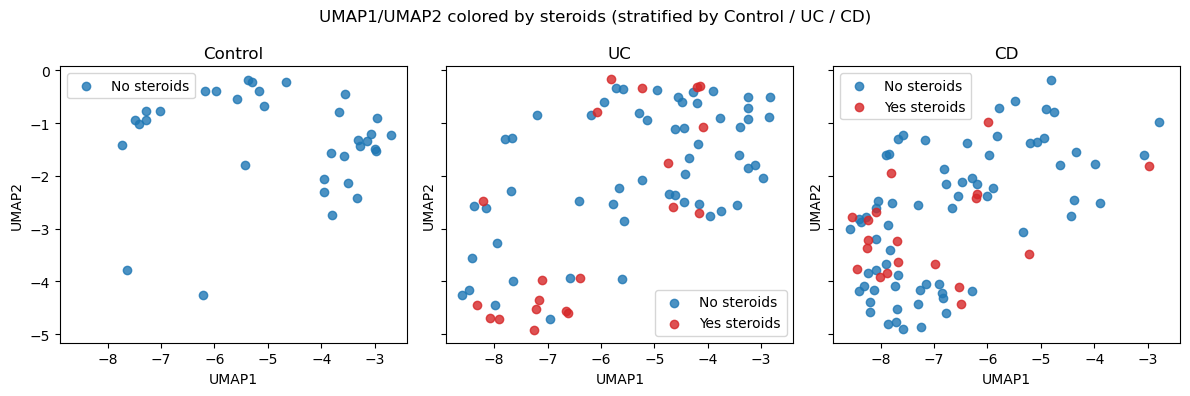

In [ ]:
for var in ["antibiotic", "immunosuppressant", "mesalamine", "steroids"]:
    # plot_by_binary_var(df_all, var, use_umap=False)   # use PCA
    plot_by_binary_var_3groups(df_all, var, use_umap=True)

# See how well IBD and non-IBD samples are separated
Extra, not important

In [ ]:
import matplotlib.pyplot as plt

def plot_ibd_vs_nonibd(df, use_umap=False):
    if use_umap:
        x_col, y_col = "UMAP1", "UMAP2"
        title = "UMAP of sample embeddings: IBD vs Non-IBD"
    else:
        x_col, y_col = "PC1", "PC2"
        title = "PCA of sample embeddings: IBD vs Non-IBD"
    
    color_map = {"Non-IBD": "tab:blue", "IBD": "tab:red"}
    
    fig, ax = plt.subplots(figsize=(6, 5))
    
    for status in ["Non-IBD", "IBD"]:
        sub = df[df["IBD_status"] == status]
        ax.scatter(
            sub[x_col],
            sub[y_col],
            c=color_map[status],
            alpha=0.8,
            label=status
        )
    
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()

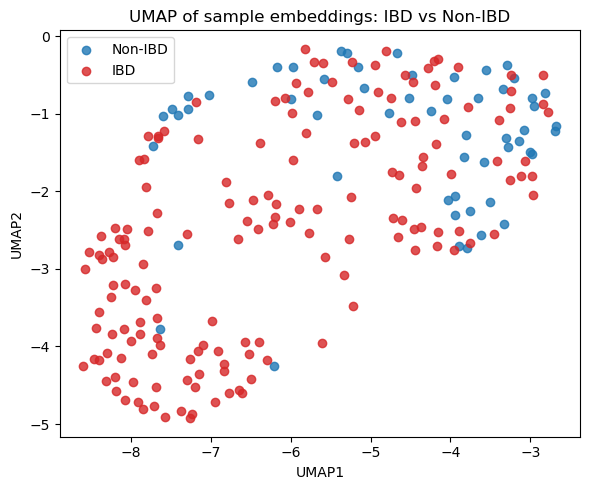

In [ ]:
plot_ibd_vs_nonibd(df_all, use_umap=True)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score

X_emb = X_scaled 

y = (df_all["IBD_status"] == "IBD").astype(int).values

print("X_emb shape:", X_emb.shape)
print("y shape:", y.shape, "IBD proportion:", y.mean())

clf = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    max_iter=1000
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = cross_val_score(
    clf,
    X_emb,
    y,
    cv=cv,
    scoring="roc_auc"
)

print("Per-fold AUC:", auc_scores)
print("Mean AUC: {:.3f} ± {:.3f}".format(auc_scores.mean(), auc_scores.std()))


X_emb shape: (220, 768)
y shape: (220,) IBD proportion: 0.7454545454545455
Per-fold AUC: [0.84848485 0.88980716 0.92286501 0.84573003 0.9453125 ]
Mean AUC: 0.890 ± 0.040
